"Предсказание пола пользователей соцсетей"

Цель: разработать модель машинного обучения, которая будет предсказывать пол пользователя соцсетей, на основе предоставленного датасета.

Задачи: 
1. Ознакомиться с предоставленными данными, импортировать и объединить разные файлы в единую таблицу.
2. Провести первичную обработку данных и предварительный анализ данных.
3. Подобрать и настроить пайплайн машинного обучения, включающий предобработку числовых и категориальных признаков.
4. Построить и обучить модель бинарной классификации на тренировочной выборке.
5. Оценить качество модели.
6. Визуализировать ключевую метрику (ROC-кривую).
7. Сделать прогноз на тестовой выборке и сформировать финальный файл с предсказаниями пола пользователей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

Данная задача является задачей бинарной классификации, решаемая методом обучения с учителем.

Импорт датасета, в котором представлены файлы с информацией о пользователях, которым показывается реклама, с их геопозицией, url'ом показа этой рекламы, временем запроса, а также target-значением (для тренировочных данных), на основе которых требуется определить пол пользователя:

In [3]:
base = "C:/Users/Вячеслав/Desktop/ML dataset/"

train = pd.read_csv(base + 'train.csv', sep=';')
train_labels = pd.read_csv(base + 'train_labels.csv', sep=';')

test = pd.read_csv(base + 'test.csv', sep=';')
test_users = pd.read_csv(base + 'test_users.csv', sep=';')

referer_vectors = pd.read_csv(base + 'referer_vectors.csv', sep=';')
geo_info = pd.read_csv(base + 'geo_info.csv', sep=';')

Объединение и преобразование признаков:

In [4]:
train_df = train.merge(train_labels, on='user_id', how='left')
train_df = train_df.merge(geo_info, on='geo_id', how='left')
train_df = train_df.merge(referer_vectors, on='referer', how='left')

test_df = test.merge(geo_info, on='geo_id', how='left')
test_df = test_df.merge(referer_vectors, on='referer', how='left')

def parse_user_agent(ua):
    try:
        d = ast.literal_eval(ua)
        return pd.Series([d.get('browser'), d.get('os')])
    except:
        return pd.Series([None, None])

ua_cols = ['browser', 'os']
train_df[ua_cols] = train_df['user_agent'].apply(parse_user_agent)
test_df[ua_cols] = test_df['user_agent'].apply(parse_user_agent)

In [5]:
train_df = train_df.drop(['referer', 'geo_id', 'user_agent'], axis=1)
test_df = test_df.drop(['referer', 'geo_id', 'user_agent'], axis=1)

In [6]:
test_df['request_ts'] = pd.to_datetime(test_df['request_ts'], unit='s')
test_df['hour'] = test_df['request_ts'].dt.hour
test_df['day_of_week'] = test_df['request_ts'].dt.dayofweek
test_df['month'] = test_df['request_ts'].dt.month
test_df = test_df.drop(columns=['request_ts'])

In [7]:
train_df['request_ts'] = pd.to_datetime(train_df['request_ts'], unit='s')
train_df['hour'] = train_df['request_ts'].dt.hour
train_df['day_of_week'] = train_df['request_ts'].dt.dayofweek
train_df['month'] = train_df['request_ts'].dt.month
train_df = train_df.drop(columns=['request_ts'])

In [8]:
train_df.head()

,user_id,target,country_id,region_id,timezone_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,browser,os,hour,day_of_week,month
0,fb858e8e0a2bec074450eaf94b627fd3,0.0,c31b4e,470e75,f6155e,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Chrome Mobile,Android,15,6,11
1,46a5f128fd569c764a92c2eaa788095e,0.0,c31b4e,44520b,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Chrome Mobile,Android,8,6,11
2,5a74e9ac53ffb21a20cce117c0ad77ba,0.0,c31b4e,616bb9,af47f1,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,Yandex Browser,Android,15,6,11
3,af735816ca19115431ae3d89518c8c91,0.0,c31b4e,3c9dca,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Chrome Mobile,Android,10,6,11
4,364f0ae0a3f29a685c4fb5bae6033b9a,0.0,c31b4e,776e76,10b7947,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Yandex Browser,Android,18,6,11


In [9]:
X = train_df.dropna(subset=['target']).drop(['target', 'user_id'], axis=1)
y = train_df["target"].dropna()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Составим Пайплайн модели, включающий L1 регуляризацию (отбор признаков из матрицы X), кодирование категориальных признаков и нормализацию значений признаков.

В качестве самой модели используем логистическую регрессию

In [10]:
numeric_cols = [c for c in X.columns if 'component' in c]
categorical_cols = ['browser', 'os', 'country_id', 'region_id', 'timezone_id']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', selector),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

Обучение модели:

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['component0', 'component1',
                                                   'component2', 'component3',
                                                   'component4', 'component5',
                                                   'component6', 'component7',
                                                   'component8',
                                                   'component9']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['browser', 'os',
                                                   'country_id', 'region_id',
                                                   'timezone_id'])])),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(max_iter=1000,
                                                              penalty='l1',
                                                              solver='liblinear'))),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Валидация:

In [12]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Средний ROC AUC по кросс-валидации (train выборка): {scores.mean():.3f}")


Средний ROC AUC по кросс-валидации (train выборка): 0.747


In [13]:
scores = cross_val_score(model, X_val, y_val, cv=5, scoring='roc_auc')
print(f"Средний ROC AUC по кросс-валидации (validation выборка): {scores.mean():.3f}")

Средний ROC AUC по кросс-валидации (validation выборка): 0.746


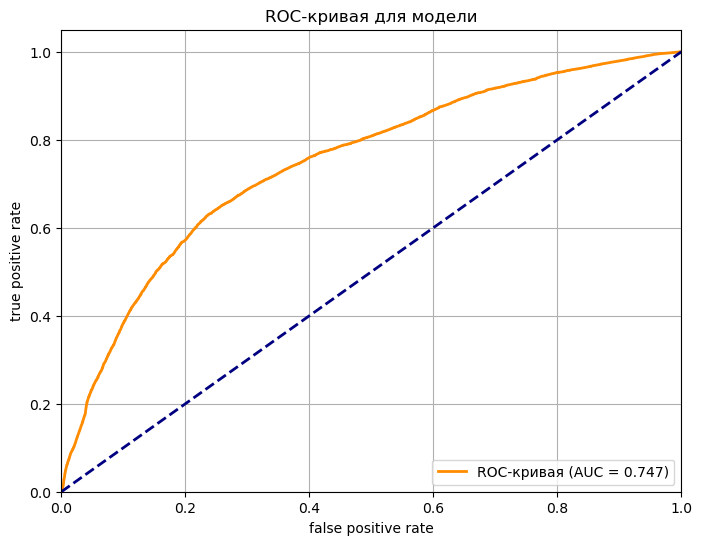

In [14]:
from sklearn.metrics import roc_curve, auc

y_val_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC-кривая для модели')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Применение модели:

In [15]:
X_test = test_df.drop(['user_id'], axis=1)
y_test_pred = model.predict(X_test)

In [16]:
test_df['target'] = y_test_pred

In [17]:
final_pred = (test_df.groupby('user_id')['target'].mean().round().astype(int).reset_index())

In [18]:
submission = test_users.merge(final_pred, on='user_id', how='left')

In [19]:
submission.rename(columns={'predicted_target': 'target'}, inplace=True)
submission.to_csv(base + 'submission.csv', sep=';', index=False)

In [20]:
submission.head()

,user_id,target
0,c2802dadd33d8ae09bb366bdd41212ea,0
1,e5b1988db74527ec092f28b0bbfdaac9,0
2,6ef1eedbdb72554e53e69782066065c5,0
3,7e057293ecae62985a327b7af51858ea,0
4,a27bd7ce8828497823fa8d5d05e7bbf7,0


В целом, цель работы выполнена — построена рабочая пайплайн-модель, которая может автоматически обрабатывать новые данные и предсказывать пол пользователя с приемлемой точностью.